In [133]:
import pandas as pd
import numpy as np
import datetime
import sqlite3
from pandas.tseries.holiday import USFederalHolidayCalendar as uscal

import requests
import json
import re

import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

#import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.inspection import permutation_importance

import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR
%matplotlib inline

In [134]:
model_prepx = pd.read_csv('zinfanel_nov_new.csv')

In [135]:
model_prepx['usage_hour_before'] = model_prepx['interval_kWh'].shift(1)
model_prep = model_prepx.dropna(subset=['usage_hour_before'])

In [136]:
training = model_prep[pd.to_datetime(model_prep['timestamp']) < '2020-11-20 00:00:00']
testing = model_prep[pd.to_datetime(model_prep['timestamp']) >= '2020-12-04 00:00:00']

In [137]:
len(training), len(testing)

(4919, 7240)

In [138]:
training['time_label'] = ['\n'.join(wrap(x, 10)) for x in training['timestamp']]
testing['time_label'] = ['\n'.join(wrap(x, 10)) for x in testing['timestamp']]

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Linear Regressor 

In [139]:
# Modeling - baseline
y = training['interval_kWh']
X = training[['temp', 'pressure', 'humidity', 
                'sunlight_No', 'sunlight_Yes', 'hour']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = LinearRegression()
lr_mod = lr.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.4668217507371289, 0.481649534774377)

### RFC Regressor

In [140]:
regressor = RandomForestRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.1326213174301979, 0.36462791111111104)

### XG-Boost Regressor

In [141]:
regressor = xgboost.XGBRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

C:\Users\szhang\AppData\Roaming\Python\Python37\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\szhang\AppData\Roaming\Python\Python37\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


(0.1834891876302395, 0.38427259081553633)

### Support Vector Regressor

In [142]:
regressor = SVR()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.8038275273527863, 0.8239592713131804)

### Extra Tree Regressor

In [143]:
regressor = ExtraTreesRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.000845757657907104, 0.3751358243902438)

### Bagging Regressor

In [144]:
regressor = BaggingRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.146449820186139, 0.38004676422764233)

### Gradient Boosting Regressor

In [145]:
regressor = GradientBoostingRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.36831212178036266, 0.39667692609748917)

## Further tuning & Additional Variables
**Testing models:**
- RFC
- Extra Tree

**Additional Features:**
- Season
- Temperature from the hour before
- Working day vs non-working day

### RFC 

In [146]:
y = training['interval_kWh']
X = training[['temp', 'pressure', 'humidity', 'usage_hour_before',
                'sunlight_No', 'sunlight_Yes', 'hour', 'hour_before', 'workday_0', "workday_1",
               'season_Fall', 'season_Winter', 'season_Spring', 'season_Summer']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                    test_size=0.25, shuffle=False)

In [147]:
# More features for RFC
regressor = RandomForestRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred_rfc = lr_mod.predict(X_test)
y_predt_rfc = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt_rfc),mean_absolute_error(y_test, y_pred_rfc)

(0.06790738519924107, 0.28844723252032534)

### Extra Trees

In [150]:
# More features for RFC
regressor = ExtraTreesRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred_et = lr_mod.predict(X_test)
y_predt_et = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt_et),mean_absolute_error(y_test, y_pred_et)

(5.102993116168109e-15, 0.2901999414634148)

### Overall:
- Extra Tree performs slightly better on testing set but with a bit of overfitting issues
- Extra Tree is performing close to perfect for training set

### GB Reg

In [153]:
regressor = GradientBoostingRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred_gb = lr_mod.predict(X_test)
y_predt_gb = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt_gb),mean_absolute_error(y_test, y_pred_gb)

(0.19002385092094154, 0.314891064079057)

### Modeling Comparison - Time Series

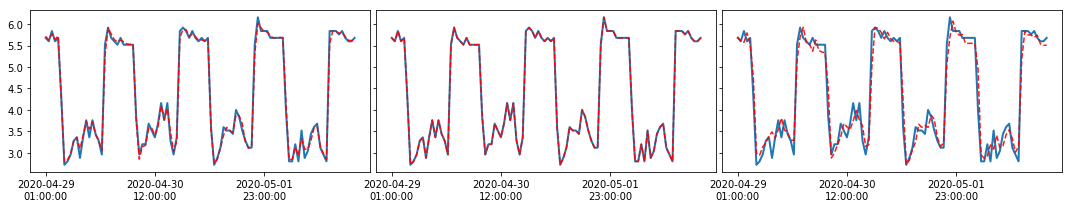

In [155]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3), sharey = True)
ax1.plot(training['time_label'][0:100], y_train[0:100], linewidth = 2, label = 'Actual kWh')
ax1.plot(training['time_label'][0:100], y_predt_rfc[0:100], alpha=0.9, color = 'r', linestyle = '--', 
        label = 'Predicted kWh')
ax1.set_xticks(training['time_label'][0:100:35])

ax2.plot(training['time_label'][0:100], y_train[0:100], linewidth = 2, label = 'Actual kWh')
ax2.plot(training['time_label'][0:100], y_predt_et[0:100], alpha=0.9, color = 'r', linestyle = '--', 
         label = 'Predicted kWh')
ax2.set_xticks(training['time_label'][0:100:35])
ax3.plot(training['time_label'][0:100], y_train[0:100], linewidth = 2, label = 'Actual kWh')
ax3.plot(training['time_label'][0:100], y_predt_gb[0:100], alpha=0.9, color = 'r', linestyle = '--', 
        label = 'Predicted kWh')
ax3.set_xticks(training['time_label'][0:100:35])
plt.tight_layout(w_pad=-1.5)

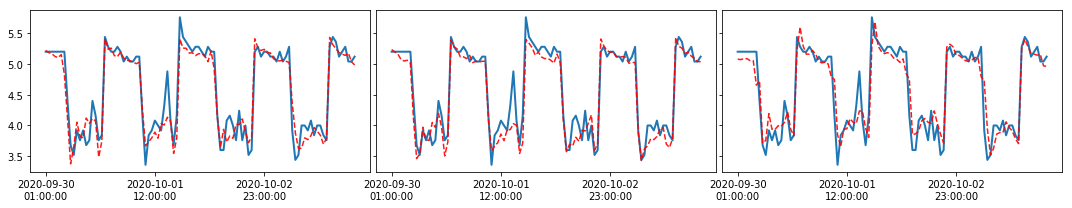

In [159]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3), sharey = True)
ax1.plot(training['time_label'][3696:3796], y_test[6:106], linewidth = 2, label = 'Actual kWh')
ax1.plot(training['time_label'][3696:3796], y_pred_rfc[6:106], alpha=0.9, color = 'r', linestyle = '--', 
        label = 'Predicted kWh')
ax1.set_xticks(training['time_label'][3696:3796:35])

ax2.plot(training['time_label'][3696:3796], y_test[6:106], linewidth = 2, label = 'Actual kWh')
ax2.plot(training['time_label'][3696:3796], y_pred_et[6:106], alpha=0.9, color = 'r', linestyle = '--', 
         label = 'Predicted kWh')
ax2.set_xticks(training['time_label'][3696:3796:35])
ax3.plot(training['time_label'][3696:3796], y_test[6:106], linewidth = 2, label = 'Actual kWh')
ax3.plot(training['time_label'][3696:3796], y_pred_gb[6:106], alpha=0.9, color = 'r', linestyle = '--', 
        label = 'Predicted kWh')
ax3.set_xticks(training['time_label'][3696:3796:35])
plt.tight_layout(w_pad=-1.5)

## Full Dataset Pre-retrofit Training & Post-retrofit Prediction

In [160]:
y_train = training['interval_kWh']
X_train = training[['temp', 'pressure', 'humidity', 'usage_hour_before',
                'sunlight_No', 'sunlight_Yes', 'hour', 'hour_before', 'workday_0', "workday_1",
               'season_Fall', 'season_Winter', 'season_Spring', 'season_Summer']]
y_test= testing['interval_kWh']
X_test = testing[['temp', 'pressure', 'humidity', 'usage_hour_before',
                'sunlight_No', 'sunlight_Yes', 'hour', 'hour_before', 'workday_0', "workday_1",
               'season_Fall', 'season_Winter', 'season_Spring', 'season_Summer']]

In [161]:
len(training), len(testing)

(4919, 7240)

### RFC

In [162]:
regressor = RandomForestRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred_rfc = lr_mod.predict(X_test)
y_predt_rfc = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt_rfc)

0.0706781166903843

In [163]:
training['pred_usage'] = y_predt_rfc
testing['pred_usage'] = y_pred_rfc

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### ET

In [165]:
regressor = ExtraTreesRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred_et = lr_mod.predict(X_test)
y_predt_et = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt_et)

5.246012564742313e-15

In [166]:
training['pred_usage_et'] = y_predt_et
testing['pred_usage_et'] = y_pred_et

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### GB

In [168]:
regressor = GradientBoostingRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred_gb = lr_mod.predict(X_test)
y_predt_gb = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt_gb)

0.2111973060305111

### Post Retrofit Data Prediction Visualization Comparison

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


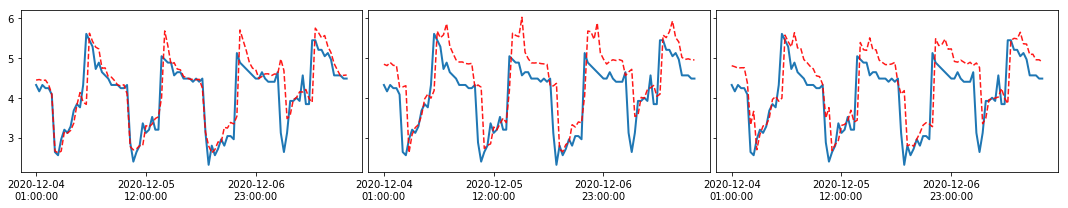

In [169]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3), sharey = True)
ax1.plot(testing['time_label'][1:101], y_test[1:101], linewidth = 2, label = 'Actual kWh')
ax1.plot(testing['time_label'][1:101], y_pred_rfc[1:101], alpha=0.9, color = 'r', linestyle = '--', 
        label = 'Predicted kWh')
ax1.set_xticks(testing['time_label'][1:101:35])

ax2.plot(testing['time_label'][1:101], y_test[1:101], linewidth = 2, label = 'Actual kWh')
ax2.plot(testing['time_label'][1:101], y_pred_et[1:101], alpha=0.9, color = 'r', linestyle = '--', 
         label = 'Predicted kWh')
ax2.set_xticks(testing['time_label'][1:101:35])
ax3.plot(testing['time_label'][1:101], y_test[1:101], linewidth = 2, label = 'Actual kWh')
ax3.plot(testing['time_label'][1:101], y_pred_gb[1:101], alpha=0.9, color = 'r', linestyle = '--', 
        label = 'Predicted kWh')
ax3.set_xticks(testing['time_label'][1:101:35])
plt.tight_layout(w_pad=-1.5)

### Saving calculation using RFC

In [130]:
testing['usage_pred_gb'] = y_pred_gb
testing['usage_pred_et'] = y_pred_et
testing['usage_pred_rfc'] = y_pred_rfc

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [131]:
testing['month_year'] = pd.to_datetime(testing['timestamp']).dt.to_period('M')
calendar_bill = pd.DataFrame(testing.groupby('month_year')['pred_usage_et', 'usage_pred_gb', 'usage_pred_rfc'].sum()).reset_index()
calendar_bill

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,month_year,pred_usage_et,usage_pred_gb,usage_pred_rfc
0,2020-12,2958.058040,2903.342205,2712.015112
1,2021-01,3246.637072,3169.261522,2987.628568
2,2021-02,2910.176528,2869.051216,2729.754000
3,2021-03,3059.507456,3019.510593,2891.746608
4,2021-04,2973.623616,2996.692716,2921.109632
5,2021-05,3101.531016,3163.077521,3152.044200
6,2021-06,3147.622064,3185.323057,3164.399616
7,2021-07,3237.952544,3301.358385,3252.761136
8,2021-08,3271.526048,3344.750440,3294.993040
9,2021-09,3193.388352,3173.502004,3186.129480
